### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab

In [3]:
import numpy as np
import feather
from datetime import datetime
import re

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Import Data & Clean

In [ ]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv', nrows=1000000)
df.head()

In [ ]:
def clean(df):
    wdf = df[~df.CompanyName.str.contains('!')].dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')
    SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '99999') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [ ]:
wdf = clean(df)

### Check for Class Imbalance

In [11]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).count().sort_values('CompanyName', ascending=False)
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

In [ ]:
plot_frequency(wdf, 'SICCode.SicText_1')

In [ ]:
min_class_count = 500
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

In [ ]:
classes[classes.CompanyName < min_class_count].sum()

### Resample Data

In [ ]:
to_replace = classes[classes.CompanyName < min_class_count].index

In [ ]:
wdf['SICCode.SicText_1'] = wdf['SICCode.SicText_1'].replace(to_replace, '0 - Unknown')

In [ ]:
plot_frequency(wdf, 'SICCode.SicText_1')

In [ ]:
def resample_class(df, y_value, freq=0.5):
    np.random.seed(0)
    criteria = np.random.rand(len(df)) < freq
    return df[(df['SICCode.SicText_1'] != y_value) | criteria]

In [ ]:
classes.sort_values('CompanyName', ascending=False)

In [ ]:
wdf = resample_class(wdf, '0 - Unknown', freq=0.33)
wdf = resample_class(wdf, '82990 - Other business support service activities n.e.c.', freq=0.66)

In [ ]:
plot_frequency(wdf, 'SICCode.SicText_1')

### Pickle Working Set

In [ ]:
feather.write_dataframe(wdf, 'wdf.feather')

In [6]:
wdf = feather.read_dataframe('wdf.feather')
wdf.head()

,CompanyName,SICCode.SicText_1
0,1 C O LTD,70229 - Management consultancy activities othe...
1,243 RUGBY ROAD MANAGEMENT COMPANY LTD,98000 - Residents property management
2,309 WEST END LANE MANAGEMENT LTD,98000 - Residents property management
3,A TASTE OF TUSCANY LTD,56101 - Licensed restaurants
4,A CERAMICS LTD,86230 - Dental practice activities


### Feature Engineering

In [8]:
wdf['Industry'] = wdf['SICCode.SicText_1'].str.split(' - ').str[0].str[0:2]

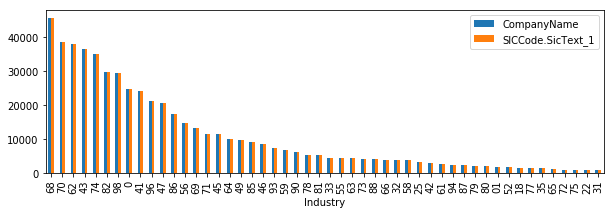

In [12]:
plot_frequency(wdf, 'Industry')

### Label Encoding

In [9]:
encoder = LabelEncoder()
encoder.fit(wdf['Industry'])
encoded_Y = encoder.transform(wdf['Industry'])
labels = np_utils.to_categorical(encoded_Y)
labels.shape

(546800, 56)

In [10]:
num_classes = labels.shape[1]

### Text Encoding

In [13]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [14]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.100d.txt', embedding_dim=100)

In [15]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [62]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize('This is an apple inc 10'))
print(custom_tokenize('what is this, an apple ltd?'))
vocab_size, embedding_dim

[37, 14, 29, 3292, 15231, 206]
[102, 14, 37, 29, 3292, 8196]


(400001, 100)

In [17]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]

In [18]:
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [19]:
# Sanity check
len(encoded_company_names), len(labels)

(546800, 546800)

### Train/Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, labels, test_size=0.25, random_state=42)
y_train.shape

(410100, 56)

### Model

In [21]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           40000100  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                56056     
Total params: 40,056,156
Trainable params: 56,056
Non-trainable params: 40,000,100
_________________________________________________________________


### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [22]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-flatten-dense%s-%s' % (
    embedding_dim, num_classes, date_suffix)
temp_folder

'tmp/GloVe100-flatten-dense56-2018-03-22 10-39-51'

### Train Model

In [23]:
model.fit(
    X_train, y_train, epochs=16,
    validation_data=(X_test, y_test),
    callbacks=[TensorBoard(log_dir=temp_folder)])

Train on 410100 samples, validate on 136700 samples
Epoch 1/16
410100/410100 [==============================] - 29s 72us/step - loss: 2.6931 - acc: 0.2927 - val_loss: 2.5886 - val_acc: 0.3078
Epoch 2/16
410100/410100 [==============================] - 29s 71us/step - loss: 2.6150 - acc: 0.3132 - val_loss: 2.5760 - val_acc: 0.3189
Epoch 3/16
410100/410100 [==============================] - 29s 71us/step - loss: 2.6081 - acc: 0.3165 - val_loss: 2.5884 - val_acc: 0.3239
Epoch 4/16
410100/410100 [==============================] - 30s 72us/step - loss: 2.6081 - acc: 0.3161 - val_loss: 2.5757 - val_acc: 0.3263
Epoch 5/16
410100/410100 [==============================] - 29s 72us/step - loss: 2.6067 - acc: 0.3158 - val_loss: 2.5636 - val_acc: 0.3240
Epoch 6/16
410100/410100 [==============================] - 29s 71us/step - loss: 2.6038 - acc: 0.3167 - val_loss: 2.5724 - val_acc: 0.3275
Epoch 7/16
410100/410100 [==============================] - 29s 71us/step - loss: 2.6053 - acc: 0.3173 - val

### Testing/Validation

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

136700/136700 [==============================] - 3s 25us/step


0.32713972201945579

In [25]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape

((136700,), (136700,))

In [26]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.327139722019


In [46]:
def plot_confusion_matrix(cm, classes):
    pylab.clf()
    cm = cm/cm.sum(axis=1)
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.6)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

/Users/zeb.zhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zeb.zhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


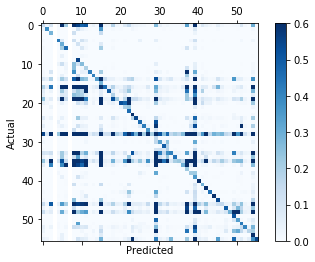

In [47]:
plot_confusion_matrix(confusion_matrix(y_pred, y_labels), [])

In [50]:
# Problematic class
confusion_matrix(y_pred, y_labels)[28, :]

array([1318,   45,   42,   44,   83,   51,  149,   53,   62,   26,  269,
        252,   30,   19,  728,  118, 1034,  346,  565, 1192,  319,   80,
         29,  132,  689,  314,  390,  321, 6413,  528,  352,   39,  132,
       1514,  615, 2904,  730,  114,  353, 2261,   17,   69,  287,   91,
        119,  147, 1799,  304,  973,   63,  142,  299,  244,   44, 1148,
        166])

In [72]:
encoder.inverse_transform(28)  # Tech Companies
confusion_matrix(y_pred, y_labels)[26, :]

array([124,   0,   0,   0,   5,   1,   2,   3,   0,   1,   5,   4,   0,
         0,   3,   1,  10,  12,  10,  32,   4,   1,   0,   2,  16,  36,
       778,   7,  87,  11,   4,   0,   1,  11,   5,  27,  13,   0,  40,
        86,   0,   2,   0,   0,   2,   0,  91,  18,  11,   0,   3, 247,
        38,   4,  73,   1])

In [55]:
len(wdf[wdf.Industry == '62'])

38048

In [71]:
encoder.transform(pd.Series(['59']))


array([26])

In [60]:
wdf[2000:2005]

,CompanyName,SICCode.SicText_1,Industry
2000,10 GRANVILLE ROAD MANAGEMENT LTD,98000 - Residents property management,98
2001,10 GREAT ORMOND STREET LTD,98000 - Residents property management,98
2002,10 GREAT PULTENEY STREET MANAGEMENT COMPANY LTD,"74909 - Other professional, scientific and tec...",74
2003,10 GREEN BOTTLES LTD,59111 - Motion picture production activities,59
2004,10 GREENAWAY GARDENS LTD,98000 - Residents property management,98


### Save Model

In [63]:
model.save('models/train%s-acc%s.h5' % (len(X_train), accuracy))

### Play with Model

In [61]:
while True:
    name = input()
    if not name:
        break
    encoded_company_name = pad_sequences([custom_tokenize(name)], maxlen=maxlen, padding='post')
    probas = sorted(enumerate(model.predict(encoded_company_name).flatten()), key=lambda x: x[1], reverse=True)[:5]
    for i, p in probas:
        print('\t%0.2f%%\t%s' % (p*100, encoder.inverse_transform(i)[:100]))

10 GRANVILLE ROAD MANAGEMENT LTD
	99.64%	98
	64.48%	68
	5.39%	55
	1.85%	74
	1.20%	41


KeyboardInterrupt: 